## Simple Higher Order Example with misspecification 

$$
\ddot x = -\sin(x)
$$

$$
\begin{align}
u_1 &\triangleq x\\
u_2 &\triangleq \dot x\\
\end{align}
$$

First order system
$$
\begin{align}
\dot u_1 &= u_2\\
\dot u_2 &= - \sin(u_1)
\end{align}
$$

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import jax
import jax.numpy as jnp
from jax.random import PRNGKey

import numpy as np
import matplotlib.pyplot as plt
import diffrax

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import CholDataAdaptedRKHSInterpolant, CholRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel, PolyLib
from jsindy.optim import (
    AlternatingActiveSetLMSolver,
    LMSettings,
    AnnealedAlternatingActiveSetLMSolver,
)
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from jsindy.kernels import ConstantKernel, ScalarMaternKernel

from jsindy.util import get_collocation_points_weights

from pysindy import STLSQ

# Configure
jax.config.update("jax_enable_x64", True)
plt.style.use("ggplot")
from jax.random import PRNGKey


In [2]:
# Random key
seed = 1234
rkey = PRNGKey(seed=seed)


In [3]:
dt = 0.005
noise = 0.1
# noise = 0.0
dt_train = 1.

n_colloc = 500

x0 = 3.0       # initial displacement
# x0 = 1.0
dx0 = 0.0      # initial velocity

t0 = 0.0
t1 = 100.0
initial_state = jnp.array([x0, dx0])

args = None

def ode_sys(t, state, args):
    x, dx = state
    dxdt = dx
    dydt = -1*jnp.sin(x)
    return jnp.array([dxdt,dydt])

term = diffrax.ODETerm(ode_sys)
solver = diffrax.Tsit5()

save_at = diffrax.SaveAt(dense=True)

sol = diffrax.diffeqsolve(
    term,
    solver,
    t0=t0,
    t1=t1,
    dt0=dt,  # Initial step size
    y0=initial_state,
    args=args,
    saveat=save_at,
    max_steps = int(10*(t1-t0)/dt)
)

In [4]:
t_true = jnp.arange(t0,t1,dt)
X_true = jax.vmap(sol.evaluate)(t_true)

t_train = jnp.arange(t0,t1, dt_train)
X_train_true = jax.vmap(sol.evaluate)(t_train)
X_train = X_train_true + noise*jax.random.normal(rkey,X_train_true.shape)

t_colloc, w_colloc = get_collocation_points_weights(t_train, n_colloc)


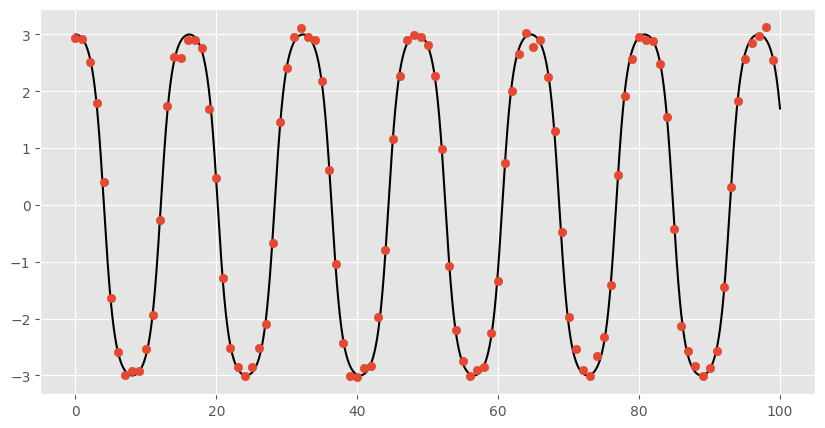

In [5]:
plt.figure(figsize=(10,5))
plt.plot(t_true, X_true[:,0],c='black')
plt.scatter(t_train, X_train[:,0],zorder=2)
plt.show()

## Fit with linear model

In [6]:

kernel = (
    ConstantKernel(variance = 5.)
    +ScalarMaternKernel(p = 5,variance = 10., lengthscale=3,min_lengthscale=0.05)
)   

trajectory_model = CholDataAdaptedRKHSInterpolant(kernel=kernel,derivative_orders=(0,1,2))
dynamics_model = FeatureLinearModel(
    reg_scaling = 1.,
    feature_map=PolyLib(degree=1)
    
)
optsettings = LMSettings(
    max_iter = 2000,
    atol_gradnorm=1e-8,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
)
data_weight = 1.
colloc_weight = 1e5
sparsifier = pySindySparsifier(STLSQ(threshold = 0.1,alpha = 0.01))
optimizer = AlternatingActiveSetLMSolver(
    beta_reg=1e-3,
    solver_settings=optsettings,
    fixed_colloc_weight=colloc_weight,
    fixed_data_weight=data_weight,
    sparsifier = sparsifier,
)

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    input_orders=(0,  ),
    ode_order=2,
    feature_names=['x']
)
model.fit(
    t = t_train,
    x = X_train[:,0].reshape(-1,1),
    t_colloc=t_colloc
)


model.print()

{'show_progress': True, 'sigma2_est': Array(0.01549001, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 100000.0}
Warm Start


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 5.721, gradnorm = 2.396e+03, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 4.965, gradnorm = 136.5, alpha = 3.472, improvement_ratio = 1.0
Iteration 2, loss = 4.941, gradnorm = 1.037, alpha = 2.894, improvement_ratio = 1.0
Iteration 3, loss = 4.934, gradnorm = 0.2213, alpha = 2.411, improvement_ratio = 1.0
Iteration 4, loss = 4.931, gradnorm = 0.1234, alpha = 2.009, improvement_ratio = 1.0
Iteration 5, loss = 4.929, gradnorm = 0.08108, alpha = 1.674, improvement_ratio = 1.0
Iteration 51, loss = 4.924, gradnorm = 9.769e-09, alpha = 0.0005723, improvement_ratio = 0.881
Model after smooth warm start
(x)'' = 0.001 1 + -0.151 x
Alternating Activeset Sparsifier
1 active coeffs changed
Active set stabilized
(x)'' = -0.151 x


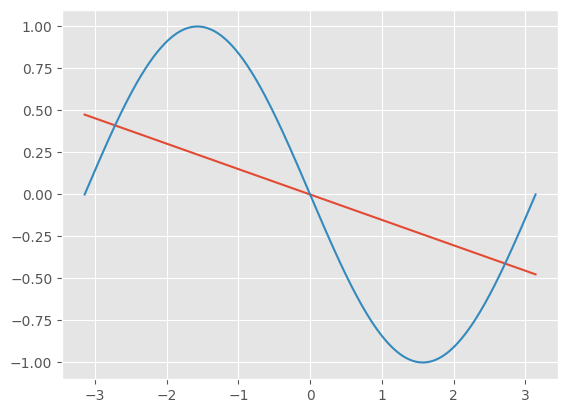

In [7]:
grid = jnp.linspace(-jnp.pi,jnp.pi,500)
plt.plot(grid,model.predict(grid[:,None]))
plt.plot(grid,-jnp.sin(grid))

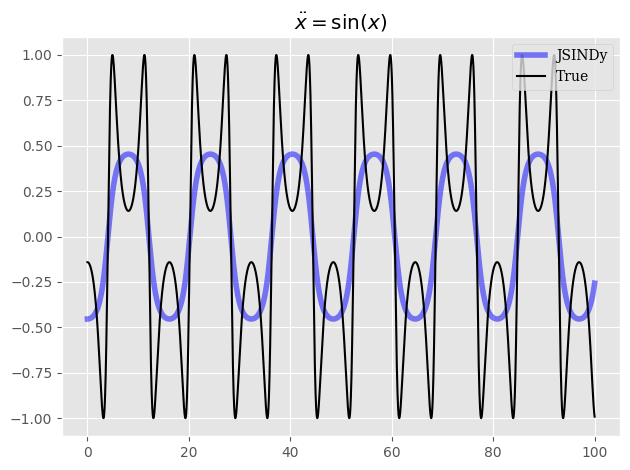

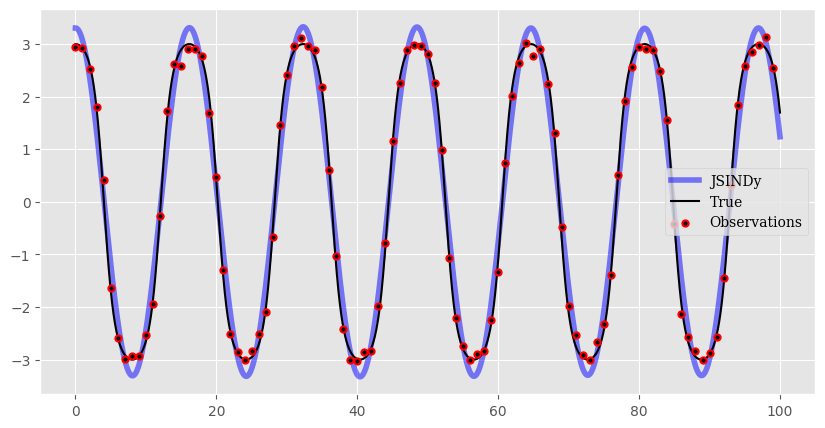

In [8]:
ddx_pred = model.predict(X_true[:,:1])

plt.plot(t_true, ddx_pred, c='blue', alpha=0.5, lw=4, label='JSINDy')
plt.plot(t_true, -jnp.sin(X_true[:,0]), c='black', label="True")
plt.title(r"$\ddot{x} = \sin(x)$", family='serif')
plt.legend(prop={'family':'serif'})
plt.tight_layout()
plt.show()

x_pred = model.predict_state(t_true)

plt.figure(figsize=(10,5))
plt.plot(t_true, x_pred, label="JSINDy", c='blue', alpha=0.5, lw=4)
plt.plot(t_true, X_true[:,0], label= 'True', c='black')
plt.scatter(t_train, X_train[:,0], zorder = 2, facecolors='black', edgecolors='red', label="Observations", s=20,lw=1.5)
plt.legend(prop={'family':'serif'})
plt.show()

In [9]:
def model_state_pred(t,state,args):
    x, dx = state
    dxdt = dx
    return jnp.array([dxdt,model.predict(jnp.array([x]))[0]])

model_term = diffrax.ODETerm(model_state_pred)

new_start = t1 - 0.02
new_init = sol.evaluate(new_start)
sol_continue = diffrax.diffeqsolve(
    term,
    solver,
    t0=new_start,
    t1=2*t1,
    dt0=dt,
    y0=new_init,
    args=args,
    saveat=save_at,
    max_steps = int(10*(t1-t0)/dt)
)

simulated_sol = diffrax.diffeqsolve(
    model_term,
    solver,
    t0=new_start,
    t1=2*t1,
    dt0=dt,
    y0=new_init,
    args=args,
    saveat=save_at,
    max_steps = int(10*(t1-t0)/dt)
)


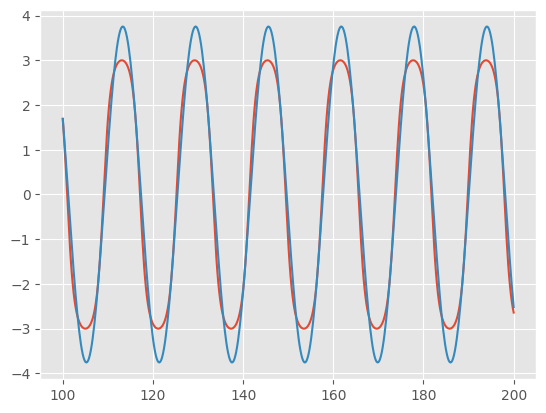

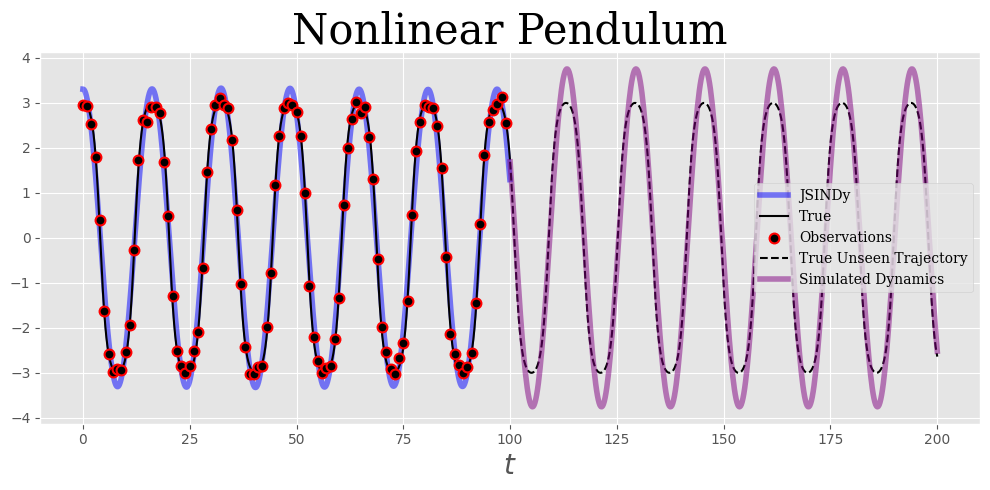

In [10]:
new_grid = jnp.linspace(t1,2*t1,500)
plt.plot(new_grid,jax.vmap(sol_continue.evaluate)(new_grid)[:,0])
plt.plot(new_grid,jax.vmap(simulated_sol.evaluate)(new_grid)[:,0])

plt.show()

true_forward = jax.vmap(sol_continue.evaluate)(new_grid)[:,0]
learned_forward = jax.vmap(simulated_sol.evaluate)(new_grid)[:,0]

cutoff = -10
plt.figure(figsize=(10,5))
plt.plot(t_true[:cutoff], x_pred[:cutoff], label="JSINDy", c='blue', alpha=0.5, lw=4)
plt.plot(t_true[:cutoff], X_true[:cutoff,0], label= 'True', c='black')
plt.scatter(t_train, X_train[:,0], zorder = 3, facecolors='black', edgecolors='red', label="Observations", s=50,lw=1.5)


plt.plot(new_grid, true_forward,linestyle="--", c='black', label="True Unseen Trajectory")
plt.plot(new_grid, learned_forward, c='purple', lw=4, label="Simulated Dynamics",alpha=0.5)

plt.xlabel(r"$t$",size=20, family='serif')
plt.legend(prop={'family':'serif'},loc='right')
plt.title(r"Nonlinear Pendulum",size=30, family='serif')
plt.tight_layout()
# if savefig: 
#     plt.savefig("non-linear-pendulum.pdf")
plt.show()

In [11]:
mse_linear = jnp.mean((X_true[:,0] - x_pred[:,0])**2,axis=0)/jnp.var(X_true[:,0],axis=0)
print(mse_linear)

0.015609555543074001


## Fit a cubic model

In [12]:
kernel = (
    ConstantKernel(variance = 5.)
    +ScalarMaternKernel(p = 5,variance = 10., lengthscale=3,min_lengthscale=0.05)
)   

trajectory_model = CholDataAdaptedRKHSInterpolant(kernel=kernel,derivative_orders=(0,1,2))
dynamics_model = FeatureLinearModel(
    reg_scaling = 1.,
    feature_map=PolyLib(degree=3)
    
)
optsettings = LMSettings(
    max_iter = 2000,
    atol_gradnorm=1e-8,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
)
data_weight = 1.
colloc_weight = 1e5
sparsifier = pySindySparsifier(STLSQ(threshold = 0.05,alpha = 0.01))
optimizer = AlternatingActiveSetLMSolver(
    beta_reg=1e-3,
    solver_settings=optsettings,
    fixed_colloc_weight=colloc_weight,
    fixed_data_weight=data_weight,
    sparsifier = sparsifier,
    # num_annealing_steps=3,
)

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    input_orders=(0, ),
    ode_order=2,
    feature_names=['x']
)
model.fit(
    t = t_train,
    x = X_train[:,0].reshape(-1,1),
    t_colloc=t_colloc
)


{'show_progress': True, 'sigma2_est': Array(0.01549001, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 100000.0}
Warm Start


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 65.42, gradnorm = 3.214e+03, alpha = 4.167, improvement_ratio = 0.9505
Iteration 1, loss = 1.596, gradnorm = 4.46e+04, alpha = 3.472, improvement_ratio = 0.9998
Iteration 2, loss = 1.355, gradnorm = 660.2, alpha = 2.894, improvement_ratio = 0.9691
Iteration 3, loss = 1.254, gradnorm = 448.2, alpha = 2.411, improvement_ratio = 0.975
Iteration 4, loss = 1.185, gradnorm = 99.72, alpha = 2.009, improvement_ratio = 0.9784
Iteration 5, loss = 1.126, gradnorm = 52.47, alpha = 1.674, improvement_ratio = 0.9792
Iteration 51, loss = 0.5839, gradnorm = 7.63e-09, alpha = 0.0004579, improvement_ratio = 0.5722
Model after smooth warm start
(x)'' = 0.001 1 + -0.796 x + 0.086 x^3
Alternating Activeset Sparsifier
2 active coeffs changed
Active set stabilized


In [13]:
model.print()

(x)'' = -0.796 x + 0.086 x^3


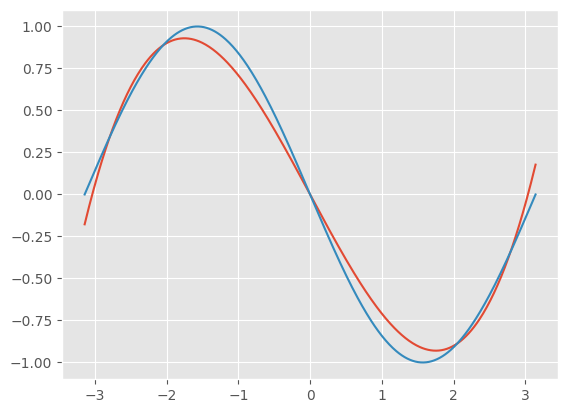

In [14]:
grid = jnp.linspace(-jnp.pi,jnp.pi,500)
plt.plot(grid,model.predict(grid[:,None]))
plt.plot(grid,-jnp.sin(grid))

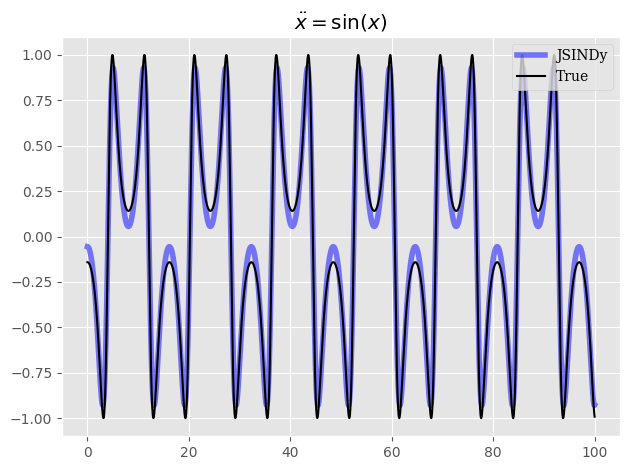

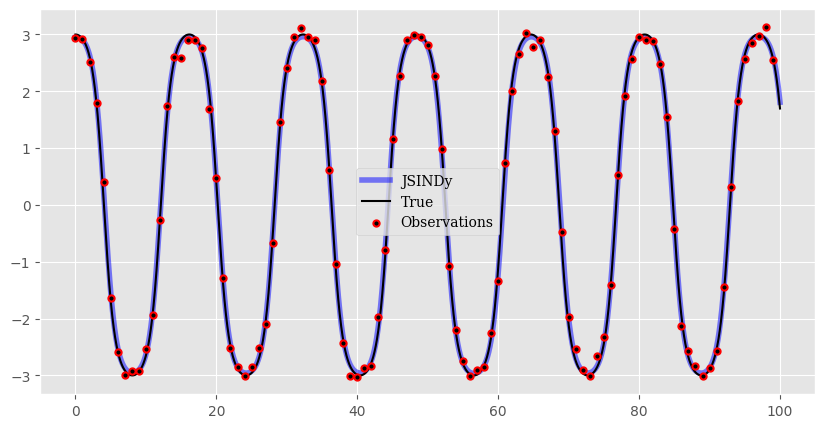

In [15]:
ddx_pred_cubic = model.predict(X_true[:,:1])

plt.plot(t_true, ddx_pred_cubic, c='blue', alpha=0.5, lw=4, label='JSINDy')
plt.plot(t_true, -jnp.sin(X_true[:,0]), c='black', label="True")
plt.title(r"$\ddot{x} = \sin(x)$", family='serif')
plt.legend(prop={'family':'serif'})
plt.tight_layout()
plt.show()

x_pred_cubic = model.predict_state(t_true)

plt.figure(figsize=(10,5))
plt.plot(t_true, x_pred_cubic, label="JSINDy", c='blue', alpha=0.5, lw=4)
plt.plot(t_true, X_true[:,0], label= 'True', c='black')
plt.scatter(t_train, X_train[:,0], zorder = 2, facecolors='black', edgecolors='red', label="Observations", s=20,lw=1.5)
plt.legend(prop={'family':'serif'})
plt.show()

In [16]:
def model_state_pred(t,state,args):
    x, dx = state
    dxdt = dx
    return jnp.array([dxdt,model.predict(jnp.array([x]))[0]])

model_term = diffrax.ODETerm(model_state_pred)

new_start = t1 - 0.02
new_init = sol.evaluate(new_start)
sol_continue = diffrax.diffeqsolve(
    term,
    solver,
    t0=new_start,
    t1=2*t1,
    dt0=dt,
    y0=new_init,
    args=args,
    saveat=save_at,
    max_steps = int(10*(t1-t0)/dt)
)

simulated_sol = diffrax.diffeqsolve(
    model_term,
    solver,
    t0=new_start,
    t1=2*t1,
    dt0=dt,
    y0=new_init,
    args=args,
    saveat=save_at,
    max_steps = int(10*(t1-t0)/dt)
)


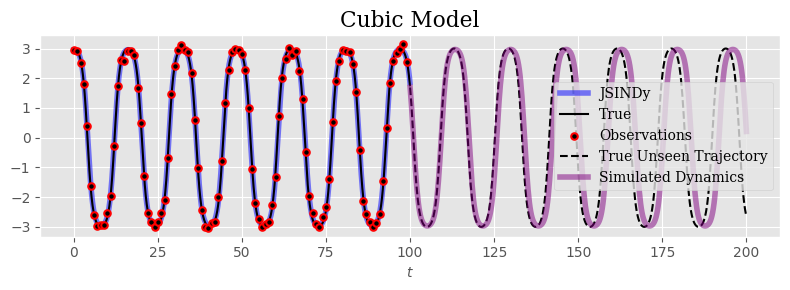

In [17]:
new_grid = jnp.linspace(t1,2*t1,500)
# plt.plot(new_grid,jax.vmap(sol_continue.evaluate)(new_grid)[:,0])
# plt.plot(new_grid,jax.vmap(simulated_sol.evaluate)(new_grid)[:,0])

# plt.show()

true_forward = jax.vmap(sol_continue.evaluate)(new_grid)[:,0]
learned_forward_cubic = jax.vmap(simulated_sol.evaluate)(new_grid)[:,0]

cutoff = -10
plt.figure(figsize=(8,3))
plt.plot(t_true[:cutoff], x_pred_cubic[:cutoff], label="JSINDy", c='blue', alpha=0.5, lw=4)
plt.plot(t_true[:cutoff], X_true[:cutoff,0], label= 'True', c='black')
plt.scatter(t_train, X_train[:,0], zorder = 3, facecolors='black', edgecolors='red', label="Observations", s=22,lw=1.5)


plt.plot(new_grid, true_forward,linestyle="--", c='black', label="True Unseen Trajectory")
plt.plot(new_grid, learned_forward_cubic, c='purple', lw=4, label="Simulated Dynamics",alpha=0.5)

plt.xlabel(r"$t$",size=10, family='serif')
plt.legend(prop={'family':'serif'},loc='right')
plt.title(r"Cubic Model",size=15.6, family='serif')
plt.tight_layout()
# if savefig: 
#     plt.savefig("non-linear-pendulum.pdf")
plt.show()

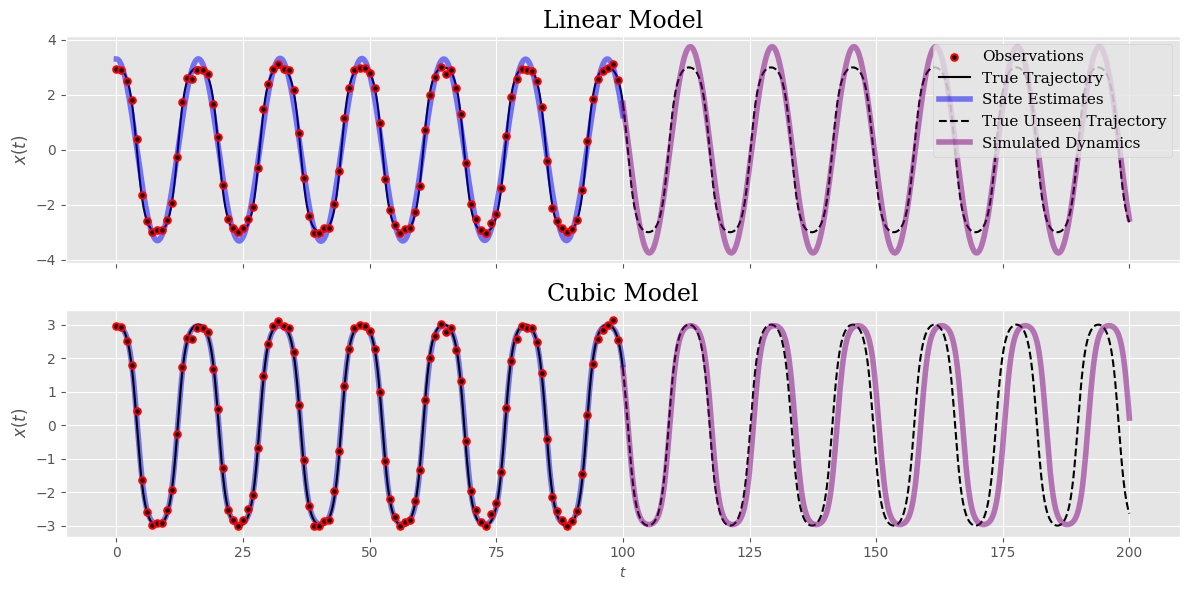

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6.), sharex=True)

cutoff = -1

# --- First subplot: Linear Model ---
ax = axs[0]
ax.scatter(t_train, X_train[:, 0], zorder=3, facecolors='black', edgecolors='red',
           label="Observations", s=22, lw=1.5)
ax.plot(t_true[:cutoff], X_true[:cutoff, 0], label='True Trajectory', c='black')
ax.plot(t_true[:cutoff], x_pred[:cutoff], label="State Estimates", c='blue', alpha=0.5, lw=4)
ax.plot(new_grid, true_forward, linestyle="--", c='black', label="True Unseen Trajectory")
ax.plot(new_grid, learned_forward, c='purple', lw=4, label="Simulated Dynamics", alpha=0.5)

ax.set_title(r"Linear Model", size=17, family='serif')
ax.set_ylabel(r"$x(t)$", family='serif')
ax.legend(prop={'family': 'serif','size' : 11}, loc='upper right')

# --- Second subplot: Cubic Model ---
ax = axs[1]
true_forward = jax.vmap(sol_continue.evaluate)(new_grid)[:, 0]
learned_forward_cubic = jax.vmap(simulated_sol.evaluate)(new_grid)[:, 0]

ax.scatter(t_train, X_train[:, 0], zorder=3, facecolors='black', edgecolors='red',
           label="Observations", s=22, lw=1.5)
ax.plot(t_true[:cutoff], x_pred_cubic[:cutoff], label="JSINDy", c='blue', alpha=0.5, lw=4)
ax.plot(t_true[:cutoff], X_true[:cutoff, 0], label='True', c='black')
ax.plot(new_grid, true_forward, linestyle="--", c='black', label="True Unseen Trajectory")
ax.plot(new_grid, learned_forward_cubic, c='purple', lw=4, label="Simulated Dynamics", alpha=0.5)

ax.set_title(r"Cubic Model", size=17, family='serif')
ax.set_xlabel(r"$t$", size=10, family='serif')
ax.set_ylabel(r"$x(t)$", family='serif')
# ax.legend(prop={'family': 'serif'}, loc='upper right')

plt.tight_layout()
plt.savefig("nonlin-pendulum-models.pdf")
plt.show()


In [19]:
mse_cubic = jnp.mean((X_true[:,0] - x_pred_cubic[:,0])**2,axis=0)/jnp.var(X_true[:,0],axis=0)
print(mse_cubic)

0.0004934672704077817
